In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
working_dir = '/content/drive/My Drive/FINA4350'
data_dir = f'{working_dir}/datasets/cashcowputer-dataset'

In [0]:
import tensorflow as tf
import tensorflow_hub as hub

In [0]:
print(tf.__version__)

2.0.0


In [0]:
module_path = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'

In [0]:
embed = hub.load(module_path)

In [0]:
messages = [
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding",
    "That band rocks!",
    "That song is really cool."]

In [0]:
message_embeddings = embed(messages)['outputs']

In [0]:
K.shape(message_embeddings)[0]

<tf.Tensor: id=188067, shape=(), dtype=int32, numpy=4>

In [0]:
batch = K.shape(message_embeddings)[0]
time_step = K.shape(message_embeddings)[1]
tf.reshape(message_embeddings,[batch,time_step,1])

<tf.Tensor: id=188093, shape=(4, 512, 1), dtype=float32, numpy=
array([[[ 0.01305106],
        [ 0.02235122],
        [-0.03263275],
        ...,
        [-0.00565098],
        [-0.04793024],
        [-0.11492755]],

       [[ 0.05833389],
        [-0.0818501 ],
        [ 0.06890936],
        ...,
        [-0.00923877],
        [-0.0869535 ],
        [-0.01415742]],

       [[ 0.00154741],
        [-0.00163464],
        [-0.00327043],
        ...,
        [-0.05142723],
        [-0.00396477],
        [ 0.00807113]],

       [[-0.01298553],
        [-0.04493096],
        [ 0.02683974],
        ...,
        [-0.05569632],
        [ 0.0405628 ],
        [ 0.02919839]]], dtype=float32)>

In [0]:
print(message_embeddings)

tf.Tensor(
[[ 0.01305106  0.02235121 -0.03263273 ... -0.00565098 -0.04793024
  -0.11492755]
 [ 0.0583339  -0.0818501   0.06890936 ... -0.00923876 -0.08695348
  -0.01415742]
 [ 0.00154741 -0.00163464 -0.00327043 ... -0.05142722 -0.00396477
   0.00807113]
 [-0.01298553 -0.04493096  0.02683973 ... -0.05569631  0.0405628
   0.0291984 ]], shape=(4, 512), dtype=float32)


# Import and prepare data

In [0]:
file_dir = '/preprocessed/preprocessed_tweet_senti_dataset.csv'

In [0]:
import pandas as pd

In [0]:
sentiment_df = pd.read_csv(data_dir+file_dir)

In [0]:
sentiment_df.head()

,ItemID,Sentiment,SentimentSource,SentimentText,cleaned_text
0,1,0,Sentiment140,is so sad for my APL frie...,is so sad for my apl friend
1,2,0,Sentiment140,I missed the New Moon trail...,i missed the new moon trailer
2,3,1,Sentiment140,omg its already 7:30 :O,omg its already o
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. Iv...,omgaga I am sooo I am gunna cry I have been at...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...,i think mi bf is cheating on me tt


In [0]:
sentiment_df.isnull().values.any()

True

In [0]:
sentiment_df = sentiment_df.dropna(axis=0)

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np

In [0]:
sentiments = sentiment_df.Sentiment.values
tweets = sentiment_df.cleaned_text.values

In [0]:
x_train, x_test, y_train, y_test = train_test_split(tweets, sentiments, test_size=.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2)

# Prepare a simple model

In [0]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [0]:
args = {
    'numberOfOutputClasses': 1,
    'embed_size': 512,
    'loss': 'binary_crossentropy',
    'optimizer': 'adagrad',
    'epochs': 15,
    'batch_size': 256,
    'activation': 'relu',
    'output_acitivation': 'sigmoid',
    'model_name': '2-DNN-keras'
}

In [0]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))['outputs']

In [0]:
input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = layers.Lambda(UniversalEmbedding, output_shape=(args['embed_size'],))(input_text)
dense = layers.Dense(256, activation=args['activation'])(embedding)
pred = layers.Dense(args['numberOfOutputClasses'], args['output_acitivation'])(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss=args['loss'], optimizer=args['optimizer'], metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda (Lambda)              (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 131,585
Trainable params: 131,585
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x_train, 
          y_train,
          validation_data=(x_val, y_val),
          epochs=args['epochs'],
          batch_size=args['batch_size'])

Train on 1010188 samples, validate on 252548 samples
Epoch 1/15
1010188/1010188 [==============================] - 487s 482us/sample - loss: 0.4838 - accuracy: 0.7762 - val_loss: 0.4680 - val_accuracy: 0.7796
Epoch 2/15
1010188/1010188 [==============================] - 450s 445us/sample - loss: 0.4646 - accuracy: 0.7814 - val_loss: 0.4644 - val_accuracy: 0.7810
Epoch 3/15
1010188/1010188 [==============================] - 449s 444us/sample - loss: 0.4620 - accuracy: 0.7824 - val_loss: 0.4626 - val_accuracy: 0.7816
Epoch 4/15
1010188/1010188 [==============================] - 449s 445us/sample - loss: 0.4604 - accuracy: 0.7831 - val_loss: 0.4613 - val_accuracy: 0.7821
Epoch 5/15
1010188/1010188 [==============================] - 447s 443us/sample - loss: 0.4593 - accuracy: 0.7836 - val_loss: 0.4604 - val_accuracy: 0.7823
Epoch 6/15
1010188/1010188 [==============================] - 453s 448us/sample - loss: 0.4585 - accuracy: 0.7839 - val_loss: 0.4596 - val_accuracy: 0.7826
Epoch 7/15


In [0]:
model.save_weights(f"{working_dir}/models/{args['model_name']}.h5")

In [0]:
import json
with open(f"{working_dir}/models/{args['model_name']}_args.json", 'w') as f:
    json.dump(args, f)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


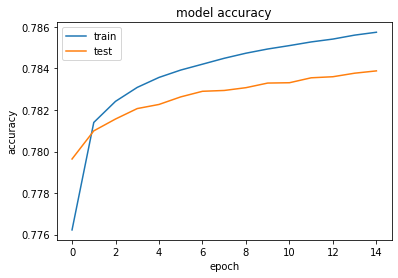

In [0]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

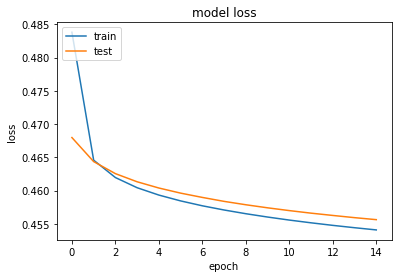

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
predicts = model.predict(x_test, batch_size=256)

In [0]:
score = model.evaluate(x_test, y_test, verbose=1)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
score[0],score[1]

(0.45537511071554193, 0.7851554)

In [0]:
map_predicts = map(lambda x: 0 if x<=0.50 else 1,predicts)

In [0]:
normalized_predicts = np.asarray(list(map_predicts))

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
data = confusion_matrix(y_test,normalized_predicts)

In [0]:
print(data)

[[120451  37467]
 [ 30356 127410]]


In [0]:
tn,fp,fn,tp = data[0][0], data[0][1], data[1][0], data[1][1]
print(f'Accruacy: {(tn+tp)/(fp+fn+tn+tp)}')
print(f'Precision: {tp/(tp+fp)}')
print(f'Recall: {tp/(fn+tp)}')

Accruacy: 0.78515540857313
Precision: 0.7727578740515657
Recall: 0.8075884537859869


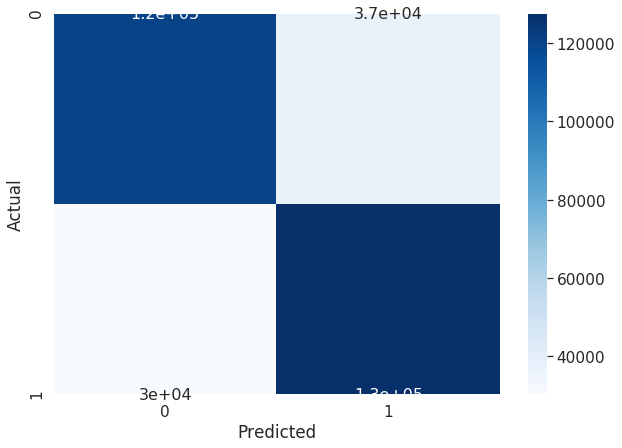

In [0]:
import seaborn as sn
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

# Prepare a CNN

In [0]:
from keras.models import Sequential

In [0]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [0]:
args = {
    'numberOfOutputClasses': 1,
    'embed_size': 512,
    'loss': 'binary_crossentropy',
    'optimizer': 'adam',
    'epochs': 15,
    'batch_size': 128,
    'output_acitivation': 'sigmoid',
    'model_name': 'LSTM-keras'
}

In [0]:
x_temp_train, x_temp_test, y_temp_train, y_temp_test = train_test_split(tweets, sentiments, test_size=.9)

In [0]:
cut_x = x_temp_train[:1000]
cut_y = y_temp_train[:1000]
cut_x_test = x_temp_test[:1000]
cut_y_test = y_temp_test[:1000]

In [0]:
cut_x_embed = UniversalEmbedding(cut_x)
cut_x_test_embed = UniversalEmbedding(cut_x_test)

In [0]:
cut_x_embed.shape,cut_x_test_embed.shape

(TensorShape([1000, 512]), TensorShape([1000, 512]))

In [0]:
test_model = tf.keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
test_model.add(layers.Embedding(input_dim=512, output_dim=512))

# Add a LSTM layer with 128 internal units.
test_model.add(layers.LSTM(256))

# Add a Dense layer with 10 units and softmax activation.
test_model.add(layers.Dense(1, activation='sigmoid'))

test_model.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['acc'])
test_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 512)         262144    
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 1,049,857
Trainable params: 1,049,857
Non-trainable params: 0
_________________________________________________________________


In [0]:
test_history = test_model.fit(cut_x_embed, 
          cut_y,
          validation_data=(cut_x_test_embed, cut_y_test),
          epochs=args['epochs'],
          batch_size=args['batch_size'])

Train on 1000 samples, validate on 1000 samples
Epoch 1/3
1000/1000 [==============================] - 8s 8ms/sample - loss: 0.6992 - acc: 0.4940 - val_loss: 0.6950 - val_acc: 0.4910
Epoch 2/3
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.6948 - acc: 0.4940 - val_loss: 0.6938 - val_acc: 0.4910
Epoch 3/3
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.6932 - acc: 0.5040 - val_loss: 0.6932 - val_acc: 0.4910


In [0]:
dump1, x_train, dump2, y_train = train_test_split(tweets, sentiments, test_size=.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2)

In [0]:
x_train.shape,x_val.shape

((252547,), (63137,))

In [0]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [0]:
def UniversalEmbedding3D(x):
    embedings = embed(tf.squeeze(tf.cast(x, tf.string)))['outputs']
    batch = K.shape(embedings)[0]
    time_step = K.shape(embedings)[1]
    return tf.reshape(embedings,[batch,time_step,1])

In [0]:
args = {
    'numberOfOutputClasses': 1,
    'embed_size': 512,
    'loss': 'binary_crossentropy',
    'optimizer': 'adam',
    'epochs': 15,
    'batch_size': 128,
    'output_acitivation': 'sigmoid',
    'model_name': 'LSTM-keras'
}

In [0]:
input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = layers.Lambda(UniversalEmbedding3D, output_shape=(None,512,1))(input_text)
lstm = layers.LSTM(128,input_shape=(512, 1))(embedding)
pred = layers.Dense(args['numberOfOutputClasses'], args['output_acitivation'])(lstm)
lstm_model = Model(inputs=[input_text], outputs=pred)
lstm_model.compile(optimizer=args['optimizer'], loss=args['loss'], metrics=['acc'])
lstm_model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
lambda_36 (Lambda)           (None, None, 1)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = lstm_model.fit(x_train, 
          y_train,
          validation_data=(x_val, y_val),
          epochs=args['epochs'],
          batch_size=args['batch_size'])

Train on 1010188 samples, validate on 252548 samples
Epoch 1/15
1010188/1010188 [==============================] - 922s 913us/sample - loss: 0.6737 - acc: 0.5799 - val_loss: 0.6711 - val_acc: 0.5833
Epoch 2/15
1010188/1010188 [==============================] - 898s 888us/sample - loss: 0.6722 - acc: 0.5802 - val_loss: 0.6707 - val_acc: 0.5849
Epoch 3/15
1010188/1010188 [==============================] - 898s 889us/sample - loss: 0.6690 - acc: 0.5886 - val_loss: 0.6636 - val_acc: 0.6010
Epoch 4/15
1010188/1010188 [==============================] - 901s 892us/sample - loss: 0.6753 - acc: 0.5683 - val_loss: 0.6462 - val_acc: 0.6266
Epoch 5/15
1010188/1010188 [==============================] - 903s 893us/sample - loss: 0.6383 - acc: 0.6362 - val_loss: 0.6299 - val_acc: 0.6468
Epoch 6/15
1010188/1010188 [==============================] - 896s 887us/sample - loss: 0.6184 - acc: 0.6586 - val_loss: 0.6015 - val_acc: 0.6757
Epoch 7/15
1010188/1010188 [==============================] - 905s 896u

In [0]:
lstm_model.save_weights(f"{working_dir}/models/{args['model_name']}.h5")

In [0]:
import json
with open(f"{working_dir}/models/{args['model_name']}_args.json", 'w') as f:
    json.dump(args, f)

In [0]:
# define documents
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.']
# define class labels
labels = np.array([1,1,1,1,1,0,0,0,0,0])
vocab_size = 50
encoded_docs = [tf.keras.preprocessing.text.one_hot(d, vocab_size) for d in docs]
print(encoded_docs)

[[40, 35], [14, 11], [11, 12], [10, 11], [47], [29], [47, 12], [24, 14], [47, 11], [43, 32, 35, 32]]
